In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from func import get_data, df_stats

### Данные 

- офферы, закрытые без ошибок, всегда присутствующие в активных
- только по Москве
- данные в трейне c 2021-02-01 по 2021-04-23
- данные в тесте c 2021-04-24 по 2021-05-01

In [4]:
def get_data():
    train_start = '2020-07-01'
    train_end = test_start = '2021-04-24'
    test_end = '2021-05-01'
    
    # read_csv
    df = pd.read_csv("data_ext.csv", sep="\t")
    df_geo = pd.read_csv("data_geo.csv", sep="\t")
    df_price = pd.read_csv("data_price.csv", sep="\t")

    # df
    df = df.merge(df_geo, "left", "offer_id").merge(df_price, "left", "offer_id")
    df["first_day_exposition"] = pd.to_datetime(df["first_day_exposition"] * 24 * 3600, unit="s")
    df["last_day_exposition"] = pd.to_datetime(df["last_day_exposition"] * 24 * 3600, unit="s")
    df = df.query("no_errors & clear")
    df = df.query("locality_name == 'Москва'").copy()
    assert df["geocoder_address"].str.contains("Россия, Москва").min() == 1
    df["day_of_week"] = df["first_day_exposition"].dt.isocalendar()["day"]
    df["first_price_sqm"] = df["first_price"] / df["area"]
    df["predicted_price_sqm"] = df["predicted_price"] / df["area"]
    df["predicted_rate"] = df["first_price"] / df["predicted_price"]

    # date_intervals
    date_range = pd.date_range(
        pd.to_datetime(train_start),
        pd.to_datetime(train_end),
        freq="7d"
    )
    date_intervals = list(zip(date_range[:-1], date_range[1:]))

    # df_train
    df_list = []
    for date_start, date_end in date_intervals:
        t = df.query("first_day_exposition >= @date_start & first_day_exposition < @date_end").copy()
        t["closed"] = (date_start + pd.Timedelta(60, "d") - t["last_day_exposition"]).dt.days > 7
        t = t[t["target"] <= 60]
        df_list.append(t)
    df_train = pd.concat(df_list)
    df_train = df_train[df_train[["district_name", "predicted_price", "min_metro_id"]].isnull().max(1) == False]

    # df_test
    date_start = pd.to_datetime(test_start)
    date_end = pd.to_datetime(test_end)
    df_test = df.query("no_errors & clear & first_day_exposition >= @date_start & first_day_exposition < @date_end").copy()
    
    df_test["closed"] = (date_start + pd.Timedelta(60, "d") - df_test["last_day_exposition"]).dt.days > 7
    df_test = df_test[df_test["target"] <= 60]
    df_test = df_test[df_test["geocoder_address"].str.contains("Россия, Москва")]
    df_test["target"] = df_test["exposition_days"]
    
    # assert
    assert df_train.shape[1] == df_test.shape[1]
    assert len(set(df_test.offer_id) & set(df_train.offer_id)) == 0
    return df_train, df_test

In [5]:
%%time
df_train, df_test = get_data()

CPU times: user 4.32 s, sys: 661 ms, total: 4.98 s
Wall time: 5.03 s


In [6]:
df_train.shape, df_test.shape

((18263, 185), (802, 185))

In [7]:
df_train["first_day_exposition"].min(), df_train["first_day_exposition"].max()

(Timestamp('2020-07-01 00:00:00'), Timestamp('2021-04-20 00:00:00'))

In [7]:
df_test["first_day_exposition"].min(), df_test["first_day_exposition"].max()

(Timestamp('2021-04-24 00:00:00'), Timestamp('2021-04-30 00:00:00'))

### Распределение тагрета

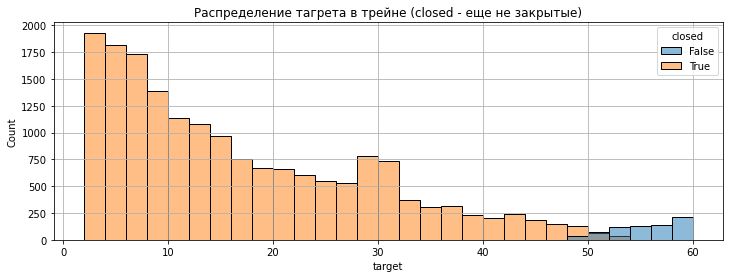

In [9]:
plt.figure(figsize=(12,4))
sns.histplot(data=df_train, x="target", hue="closed", binwidth=2)
plt.grid()
_ = plt.title("Распределение тагрета в трейне (closed - еще не закрытые)")

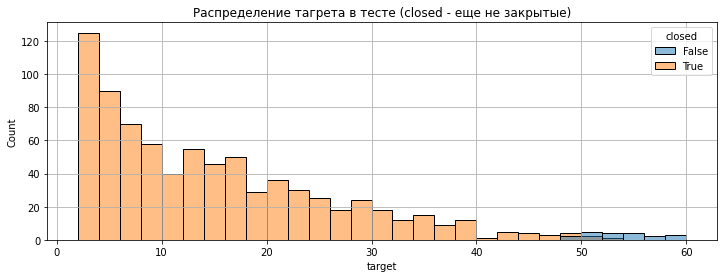

In [9]:
plt.figure(figsize=(12,4))
sns.histplot(data=df_test, x="target", hue="closed", binwidth=2)
plt.grid()
_ = plt.title("Распределение тагрета в тесте (closed - еще не закрытые)")

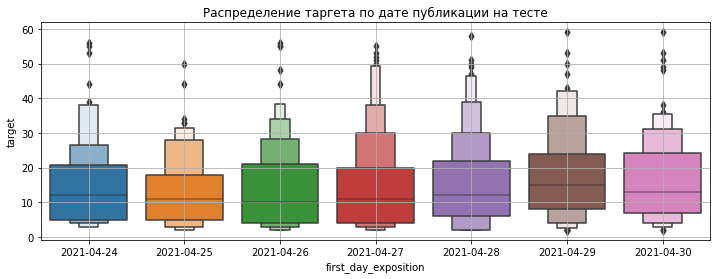

In [10]:
plt.figure(figsize=(12,4))
order = df_test["first_day_exposition"].value_counts().sort_index().index.astype("str")
sns.boxenplot(x=df_test["first_day_exposition"].astype("str"), y=df_test["target"], order=order)
plt.grid()
_ = plt.title("Распределение таргета по дате публикации на тесте")

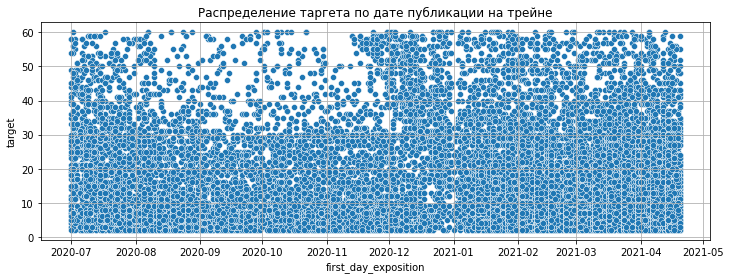

In [12]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df_train["first_day_exposition"], y=df_train["target"])
plt.grid()
_ = plt.title("Распределение таргета по дате публикации на трейне")

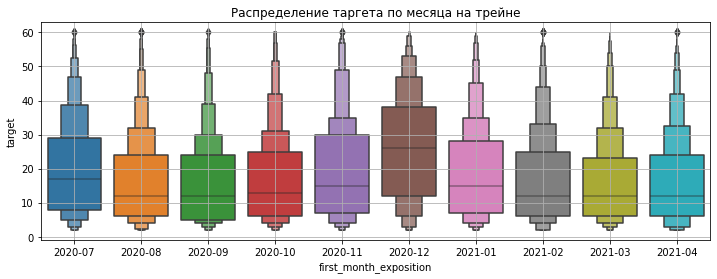

In [13]:
df_train["first_month_exposition"] = df_train["first_day_exposition"].astype("str").str[:7]
plt.figure(figsize=(12,4))
order = df_train["first_month_exposition"].value_counts().sort_index().index
sns.boxenplot(x=df_train["first_month_exposition"], y=df_train["target"], order=order)
plt.grid()
_ = plt.title("Распределение таргета по месяца на трейне")

In [14]:
df_train.groupby("first_month_exposition")["target"].describe()

,count,mean,std,min,25%,50%,75%,max
first_month_exposition,,,,,,,,
2020-07,1587.0,20.329553,14.357414,2.0,8.0,17.0,29.0,60.0
2020-08,1368.0,16.340643,13.085260,2.0,6.0,12.0,24.0,60.0
2020-09,1069.0,16.031805,12.891688,2.0,5.0,12.0,24.0,60.0
2020-10,1103.0,16.763373,13.502411,2.0,6.0,13.0,25.0,60.0
2020-11,1210.0,19.226446,14.767118,2.0,7.0,15.0,30.0,60.0
2020-12,1487.0,26.092132,16.166745,2.0,12.0,26.0,38.0,60.0
2021-01,2332.0,18.441681,13.924893,2.0,7.0,15.0,28.0,60.0
2021-02,2606.0,16.678051,13.648745,2.0,6.0,12.0,25.0,60.0
2021-03,3159.0,15.913897,13.077285,2.0,6.0,12.0,23.0,60.0


### Распределение фич
используемых в бейзлайне 

In [15]:
# + last_price / area
used_cols = ["rooms_offered", "segment", "area"]

In [16]:
X_train = df_train[used_cols].copy()
X_train["price_sqm"] = df_train["last_price"] / df_train["area"]
X_test = df_test[used_cols].copy()
X_test["price_sqm"] = df_test["last_price"] / df_test["area"]

y_train = df_train["target"]
y_test = df_test["target"]

weight_test = df_test["last_price"]
assert weight_test.isnull().sum() == 0

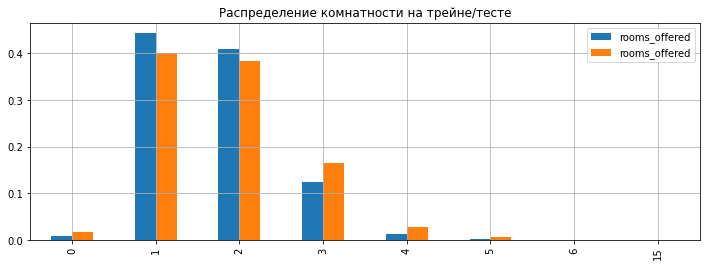

In [17]:
_, ax = plt.subplots(figsize=(12,4))
pd.concat((
    X_train["rooms_offered"].value_counts(normalize=True),
    X_test["rooms_offered"].value_counts(normalize=True)
), axis=1).plot(kind="bar", ax=ax)
plt.grid()
_ = plt.title("Распределение комнатности на трейне/тесте")

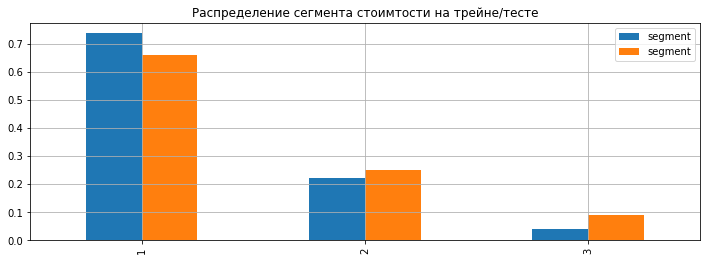

In [18]:
_, ax = plt.subplots(figsize=(12,4))
pd.concat((
    X_train["segment"].value_counts(normalize=True),
    X_test["segment"].value_counts(normalize=True)
), axis=1).plot(kind="bar", ax=ax)
plt.grid()
_ = plt.title("Распределение сегмента стоимтости на трейне/тесте")

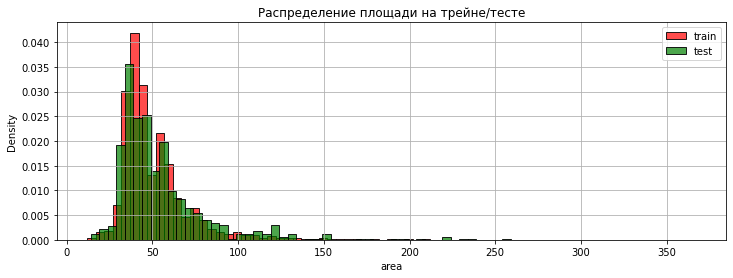

In [45]:
plt.figure(figsize=(12,4))
sns.histplot(data=df_train, x="area", label="train", color="r", stat="density", alpha=0.7, binwidth=5)
sns.histplot(data=df_test, x="area", label="test", color="g", stat="density", alpha=0.7, binwidth=5)
plt.legend()
plt.grid()
_ = plt.title("Распределение площади на трейне/тесте")

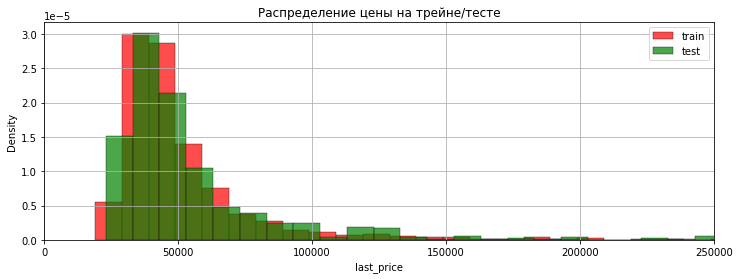

In [49]:
plt.figure(figsize=(12,4))
sns.histplot(data=df_train, x="last_price", label="train", color="r", stat="density", alpha=0.7, binwidth=10000)
sns.histplot(data=df_test, x="last_price", label="test", color="g", stat="density", alpha=0.7, binwidth=10000)
plt.legend()
plt.xlim((0, 250000))
plt.grid()
_ = plt.title("Распределение цены на трейне/тесте")